**Load the Data**

In [1]:
import pandas as pd

# Define paths to the datasets
customers_path = "Customers.csv"
products_path = "Products.csv"
transactions_path = "Transactions.csv"

# Load the datasets
customers = pd.read_csv(customers_path)
products = pd.read_csv(products_path)
transactions = pd.read_csv(transactions_path)

# Display the first few rows of each dataset
print("Customers Data:")
print(customers.head())

print("\nProducts Data:")
print(products.head())

print("\nTransactions Data:")
print(transactions.head())


Customers Data:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Products Data:
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31

Transactions Data:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127 

**Data Preprocessing**


1.Merge the transactions dataset with customers and products to get a comprehensive dataset.


2.Handle missing values and clean the data if necessary.

In [2]:
# Merge datasets
merged_data = transactions.merge(customers, on='CustomerID', how='left')
merged_data = merged_data.merge(products, on='ProductID', how='left')

# Display merged data
print("Merged Data:")
print(merged_data.head())

# Handle missing values
merged_data = merged_data.dropna()

# Verify no missing values remain
print("Missing values in merged data:", merged_data.isnull().sum().sum())


Merged Data:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  Price_x     CustomerName         Region  SignupDate  \
0      300.68   300.68   Andrea Jenkins         Europe  2022-12-03   
1      300.68   300.68  Brittany Harvey           Asia  2024-09-04   
2      300.68   300.68  Kathryn Stevens         Europe  2024-04-04   
3      601.36   300.68  Travis Campbell  South America  2024-04-11   
4      902.04   300.68    Timothy Perez         Europe  2022-03-15   

                       ProductName     Category  Price_y  
0  ComfortLiving Bluetooth Speaker  Electronics   300.68  
1  ComfortLiving Blue

**Feature Engineering**


Extract relevant features for clustering, such as:

Total transaction amount per customer.

Number of unique products purchased.

Frequency of purchases.

In [3]:
# Verify column names
print(merged_data.columns)

# Ensure 'TransactionAmount' exists or calculate it
if 'TotalValue' not in merged_data.columns:
    merged_data['TotalValue'] = merged_data['Quantity'] * merged_data['Price']  # Example

# Perform aggregation
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count',  # Ensure TransactionID exists
    'ProductID': 'nunique'  # Ensure ProductID exists
}).reset_index()

# Rename columns for clarity
customer_features.columns = ['CustomerID', 'TotalSpent', 'TotalValue', 'UniqueProducts']

# Display the resulting features
print("Customer Features:")
print(customer_features.head())


Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price_x', 'CustomerName', 'Region',
       'SignupDate', 'ProductName', 'Category', 'Price_y'],
      dtype='object')
Customer Features:
  CustomerID  TotalSpent  TotalValue  UniqueProducts
0      C0001     3354.52           5               5
1      C0002     1862.74           4               4
2      C0003     2725.38           4               4
3      C0004     5354.88           8               8
4      C0005     2034.24           3               3


**Normalize the Features**


Normalize the features to ensure they are on the same scale before clustering.

In [4]:
from sklearn.preprocessing import StandardScaler

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.iloc[:, 1:])

print("Scaled Features (first 5 rows):")
print(scaled_features[:5])


Scaled Features (first 5 rows):
[[-0.06170143 -0.01145819  0.05004655]
 [-0.87774353 -0.46749414 -0.42420409]
 [-0.40585722 -0.46749414 -0.42420409]
 [ 1.03254704  1.35664965  1.47279848]
 [-0.78392861 -0.92353008 -0.89845473]]


**Perform Clustering**

Choose a clustering algorithm (e.g., KMeans) and determine the optimal number of clusters using the Elbow Method.

C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment v

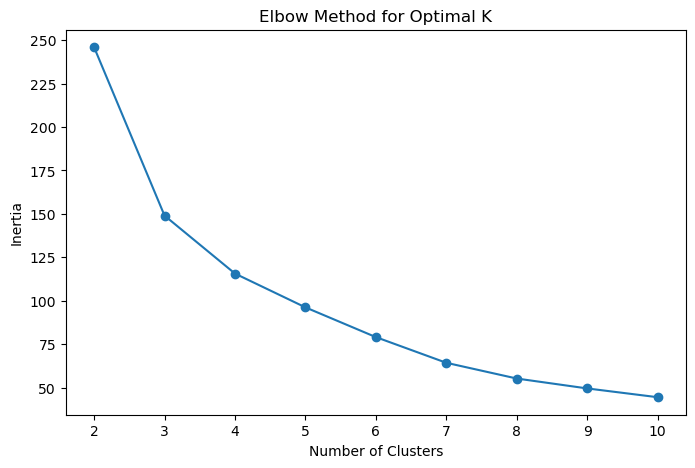

In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine the optimal number of clusters using the Elbow Method
inertia = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()


**Fit the Final Model and Assign Clusters**

Choose the number of clusters based on the Elbow Method and fit the final KMeans model.

In [6]:
# Fit the final KMeans model with the chosen number of clusters (e.g., 4)
optimal_k = 4  # Replace this with your chosen value
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)

# Display cluster assignments
print("Cluster Assignments:")
print(customer_features.head())


C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster Assignments:
  CustomerID  TotalSpent  TotalValue  UniqueProducts  Cluster
0      C0001     3354.52           5               5        2
1      C0002     1862.74           4               4        1
2      C0003     2725.38           4               4        1
3      C0004     5354.88           8               8        0
4      C0005     2034.24           3               3        1


**Evaluate the Clustering Performance**

Calculate clustering metrics such as the Davies-Bouldin Index.

In [7]:
from sklearn.metrics import davies_bouldin_score

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, customer_features['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")


Davies-Bouldin Index: 0.8081741157829814


**Visualize the Clusters**

Use a visualization technique (e.g., PCA or TSNE) to reduce dimensionality and plot the clusters.

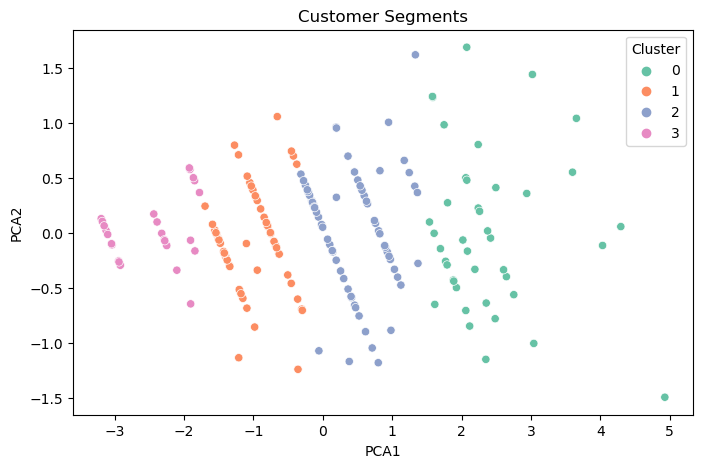

In [8]:
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Add reduced dimensions to the DataFrame
customer_features['PCA1'] = reduced_features[:, 0]
customer_features['PCA2'] = reduced_features[:, 1]

# Plot the clusters
plt.figure(figsize=(8, 5))
sns.scatterplot(data=customer_features, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title("Customer Segments")
plt.show()


**Save the Results**
Export the clustering results for further use or analysis.

In [9]:
# Save the clustered data
customer_features.to_csv('Customer_Clusters.csv', index=False)
print("Clustered data saved to Customer_Clusters.csv")


Clustered data saved to Customer_Clusters.csv
